In [103]:
#--------Import packages
#--------For Netcdf manipulation
import xarray as xr
from netCDF4 import Dataset
import netCDF4 as nc

#--------For array manipulation
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Grouper

#--------For plotting
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap # plots maps
from matplotlib.cbook import dedent
#import cmocean
import seaborn as sns

# SAM x SIV

In [104]:
#-----Read in volume dataset as dataframe
vol_df = pd.read_csv('/Users/fridaperez/Developer/repos/local_repo/CCF/vol_mean_ea.csv')
#-----Read in SAM as dataframe
sam_df = pd.read_csv('/Users/fridaperez/Developer/repos/local_repo/AtmosIndex/sam_long.csv',parse_dates=['Dates'])
#-----Read in dates  as dataframe
dates_df = pd.read_csv('/Users/fridaperez/Developer/repos/local_repo/CCF/dates_df.csv')

In [105]:
dates_df['Dates'] = dates_df['Dates'].astype('datetime64[ns]')

In [106]:
sam_df = sam_df.drop(["Years", "Months"], axis=1)

In [107]:
# Get dates  for only May -October
sam_df = sam_df[(sam_df.Dates.dt.month >= 5) & (sam_df.Dates.dt.month <= 10)]
# Here we set the index so that we can filter using iloc
sam_df = sam_df.set_index('Dates')
sam_df = sam_df.loc['2002-05-01':'2018-10-01']
## Removing the first 5 rows/dates
sam_df  = sam_df.iloc[5:]

In [108]:
# we now want the 'Dates' as a normal column and not an index
sam_df = sam_df.reset_index()
# Combining the SAM and SIV Dates
df_new = sam_df.copy()
df_new["Volume"] = vol_df["volume"]

# calculate cross correlation


In [109]:
import numpy as np
import statsmodels.api as sm
## SAM and SIV ##
sm.tsa.stattools.ccf(df_new.SAM, df_new.Volume, adjusted=False)

array([-0.15751055, -0.11848982, -0.09379683, -0.09750626, -0.20266632,
       -0.1408083 , -0.12258341, -0.03601615, -0.01910633, -0.14474659,
       -0.13914584, -0.1041509 , -0.12498418, -0.01468121,  0.00542433,
       -0.01956862, -0.09362063, -0.07814187, -0.05767004, -0.08941578,
        0.08370591, -0.01585921,  0.00561628,  0.01207523,  0.04364574,
        0.07319336,  0.15899984,  0.03885892,  0.01849592, -0.06561381,
       -0.03879304,  0.01156518,  0.09032961,  0.00895082,  0.0016567 ,
       -0.00824203, -0.00663548,  0.05267071,  0.14580478,  0.03243335,
       -0.04661855, -0.1310851 , -0.06686819,  0.05933638,  0.14999544,
        0.10862191, -0.00589816,  0.03317223,  0.05086532,  0.12007878,
        0.1806563 ,  0.10700182,  0.0093453 , -0.01573328, -0.00375252,
        0.10415034,  0.12571485,  0.1329827 ,  0.03274079, -0.01271464,
        0.02982964,  0.06250757,  0.11158942,  0.01562589, -0.0084393 ,
       -0.02217324,  0.00393703,  0.03551093,  0.09209388,  0.03

In [110]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   97 non-null     datetime64[ns]
 1   SAM     97 non-null     float64       
 2   Volume  97 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.4 KB


In [111]:
# make a dataframe just for volume
df_vol = df_new[['Dates','Volume']]
df_vol['Dates'] = dates_df['Dates'].dt.to_period('M')
df_vol = df_vol.set_index(['Dates'])

/var/folders/f1/8zx2wbhx4vb8626x_99mwyx40000gn/T/ipykernel_63566/3839699847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['Dates'] = dates_df['Dates'].dt.to_period('M')


In [112]:
# make a dataframe just for SAM
df_sam = df_new[['Dates','SAM']]
df_sam['Dates'] = dates_df['Dates'].dt.to_period('M')
df_sam = df_sam.set_index(['Dates'])

/var/folders/f1/8zx2wbhx4vb8626x_99mwyx40000gn/T/ipykernel_63566/2807624462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sam['Dates'] = dates_df['Dates'].dt.to_period('M')


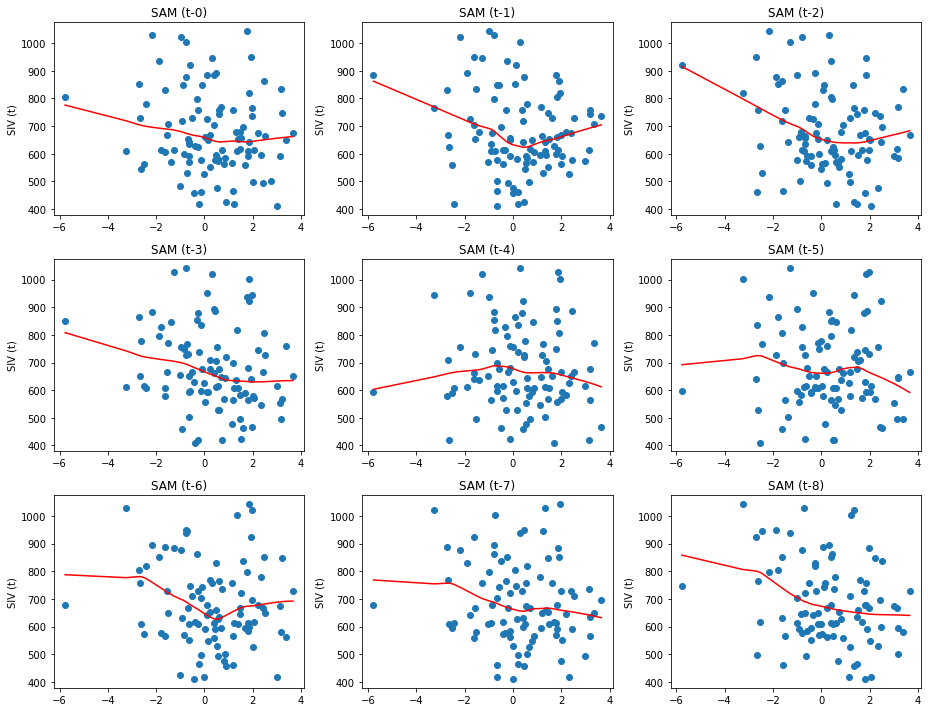

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols

from astsadata import *


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 10))

lag = 0
for row in range(3):
    for col in range(3):
        lowess = sm.nonparametric.lowess(df_vol.iloc[:, 0], df_sam.iloc[:, 0].shift(lag))
        axes[row, col].scatter(df_sam.shift(lag), df_vol)
        axes[row, col].set_title(f"SAM (t-{lag})")
        axes[row, col].set_ylabel("SIV (t)")
        axes[row, col].plot(lowess[:, 0], lowess[:, 1], color="red")
        lag += 1

fig.tight_layout()
plt.savefig("/Users/fridaperez/Developer/repos/local_repo/pub_plots/EA_ccf_SAM.png", dpi=300)

# SOI x SIV

In [114]:
#-----Read in SOI as dataframe
soi_df = pd.read_csv('/Users/fridaperez/Developer/repos/local_repo/AtmosIndex/SOI_index.csv')

In [115]:
# have to use pandas melt to go from wide to long data
soi_melt = pd.melt(soi_df, id_vars='Years')
soi_melt = soi_melt.rename(columns={"variable":"Month"})
soi_melt['Dates'] = pd.to_datetime(soi_melt[['Years', 'Month']].assign(DAY=1))

In [116]:
soi_melt = soi_melt.drop(["Years", "Month"], axis=1)
soi_melt['Dates'] = soi_melt['Dates'].astype('datetime64[ns]')

In [117]:
soi_melt

,value,Dates
0,1.0,1866-01-01
1,1.2,1867-01-01
2,-0.2,1868-01-01
3,1.5,1869-01-01
4,-2.3,1870-01-01
...,...,...
1879,-1.1,2018-12-01
1880,1.1,2019-12-01
1881,-0.8,2020-12-01
1882,-0.8,2021-12-01


In [118]:
# Get dates  for only May -October
soi_melt = soi_melt[(soi_melt.Dates.dt.month >= 5) & (soi_melt.Dates.dt.month <= 10)]
# Here we set the index so that we can filter using iloc
soi_melt = soi_melt.set_index('Dates')
soi_melt = soi_melt.loc['2002-05-01':'2018-10-01']
# ## Removing the first 5 rows/dates
soi_melt  = soi_melt.iloc[5:]

In [119]:
# # we now want the 'Dates' as a normal column and not an index
soi_melt = soi_melt.reset_index()
soi_melt.rename(columns = {'SOI':'value'}, inplace = True)

# # Combining the SAM and SIV Dates
df_new_soi = soi_melt.copy()
df_new_soi["Volume"] = vol_df["volume"]

In [120]:
df_new_soi.reset_index()

,index,Dates,value,Volume
0,0,2007-05-01,0.9,484.391924
1,1,2008-05-01,1.3,569.883316
2,2,2009-05-01,-0.3,578.503829
3,3,2010-05-01,-0.7,655.359084
4,4,2011-05-01,1.1,651.830940
...,...,...,...,...
92,92,2014-10-01,1.0,678.145248
93,93,2015-10-01,3.2,643.797937
94,94,2016-10-01,-0.2,846.980728
95,95,2017-10-01,-1.2,635.923255


In [121]:
df_new_soi.rename(columns = {'value':'SOI'}, inplace = True)

In [122]:
df_new_soi

,Dates,SOI,Volume
0,2007-05-01,0.9,484.391924
1,2008-05-01,1.3,569.883316
2,2009-05-01,-0.3,578.503829
3,2010-05-01,-0.7,655.359084
4,2011-05-01,1.1,651.830940
...,...,...,...
92,2014-10-01,1.0,678.145248
93,2015-10-01,3.2,643.797937
94,2016-10-01,-0.2,846.980728
95,2017-10-01,-1.2,635.923255


# Calculate cross correlation


In [123]:
import numpy as np
import statsmodels.api as sm
## SOI and SIV ##
sm.tsa.stattools.ccf(df_new_soi.SOI, df_new_soi.Volume, adjusted=False)

array([-0.11024005, -0.13912116, -0.14111118, -0.12685296, -0.16402167,
       -0.15212095, -0.24885823, -0.23246958, -0.29272701, -0.24219373,
       -0.07888615, -0.01313377, -0.17052674, -0.16420858, -0.15749614,
       -0.15711799, -0.06532075,  0.01683709, -0.10140528, -0.09361213,
       -0.10553392, -0.13012457, -0.06520825,  0.03905559, -0.04256145,
       -0.05051474, -0.09194339, -0.13482105, -0.02259491, -0.05898281,
       -0.08957184,  0.0168859 , -0.02713959, -0.09392469,  0.0159367 ,
        0.03639437, -0.06656271, -0.02483462, -0.03348804, -0.02008609,
        0.04966641,  0.068787  , -0.06139644, -0.01674863, -0.04043535,
        0.01331676,  0.02625137,  0.0533678 ,  0.0076018 ,  0.00390242,
       -0.00632115, -0.03507427,  0.08973428,  0.09642691,  0.04537609,
        0.02495533,  0.00734318, -0.02751128,  0.06891905,  0.09924782,
        0.0529218 ,  0.03411399,  0.02225571,  0.00556532,  0.10611883,
        0.1517113 ,  0.06218613,  0.08376272,  0.03937947,  0.01

In [124]:
df_new_soi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   97 non-null     datetime64[ns]
 1   SOI     97 non-null     float64       
 2   Volume  97 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.4 KB


In [125]:
# make a dataframe just for SAM
df_soi = df_new_soi[['Dates','SOI']]
df_soi['Dates'] = dates_df['Dates'].dt.to_period('M')
df_soi = df_soi.set_index(['Dates'])

/var/folders/f1/8zx2wbhx4vb8626x_99mwyx40000gn/T/ipykernel_63566/3364882542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soi['Dates'] = dates_df['Dates'].dt.to_period('M')


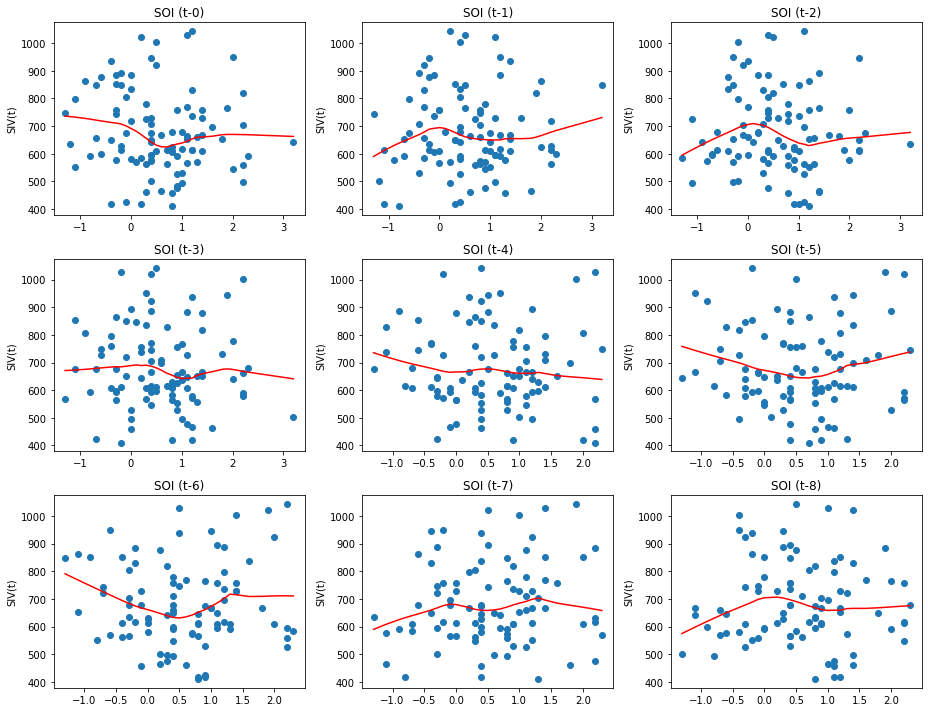

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols

from astsadata import *


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 10))

lag = 0
for row in range(3):
    for col in range(3):
        lowess = sm.nonparametric.lowess(df_vol.iloc[:, 0], df_soi.iloc[:, 0].shift(lag))
        axes[row, col].scatter(df_soi.shift(lag), df_vol)
        axes[row, col].set_title(f"SOI (t-{lag})")
        axes[row, col].set_ylabel("SIV(t)")
        axes[row, col].plot(lowess[:, 0], lowess[:, 1], color="red")
        lag += 1

fig.tight_layout()
plt.savefig("/Users/fridaperez/Developer/repos/local_repo/pub_plots/EA_ccf_SOI.png", dpi=300)


# ASL x SIV

In [127]:
#-----Read in ASL as dataframe
asl_df = pd.read_csv('/Users/fridaperez/Developer/repos/local_repo/AtmosIndex/ASL_index.csv')

In [128]:
asl_df

,Dates,Lon,Lat,ActCenPres,SectorPres,RelCenPres
0,2002-10-01,287.50,-65.75,986.911499,992.61320,-5.701721
1,2002-11-01,210.75,-71.50,988.258850,990.67206,-2.413208
2,2002-12-01,260.00,-67.00,976.395447,982.10020,-5.704773
3,2003-01-01,277.25,-63.00,986.213196,990.83466,-4.621460
4,2003-02-01,270.75,-66.50,976.448608,985.44165,-8.993042
...,...,...,...,...,...,...
227,2021-09-01,243.25,-70.50,962.242188,971.92790,-9.685730
228,2021-10-01,251.25,-69.50,959.429382,973.15680,-13.727417
229,2021-11-01,255.75,-70.00,966.653748,975.75385,-9.100098
230,2021-12-01,253.25,-71.25,968.441101,976.56810,-8.127014


In [129]:
asl_df = asl_df.drop(["Lon", "Lat","SectorPres", "RelCenPres"], axis=1)
asl_df['Dates'] = asl_df['Dates'].astype('datetime64[ns]')
print(asl_df)

         Dates  ActCenPres
0   2002-10-01  986.911499
1   2002-11-01  988.258850
2   2002-12-01  976.395447
3   2003-01-01  986.213196
4   2003-02-01  976.448608
..         ...         ...
227 2021-09-01  962.242188
228 2021-10-01  959.429382
229 2021-11-01  966.653748
230 2021-12-01  968.441101
231 2022-01-01  978.003418

[232 rows x 2 columns]


In [130]:
# Get dates  for only May -October
asl_df = asl_df[(asl_df.Dates.dt.month >= 5) & (asl_df.Dates.dt.month <= 10)]
# Here we set the index so that we can filter using iloc
asl_df = asl_df.set_index('Dates')
asl_df = asl_df.loc['2002-05-01':'2018-10-01']
# ## Removing the first 5 rows/dates
#asl_df  = asl_df.iloc[5:]
print(asl_df)

            ActCenPres
Dates                 
2002-10-01  986.911499
2003-05-01  967.435608
2003-06-01  985.111511
2003-07-01  969.911377
2003-08-01  972.973511
...                ...
2018-06-01  972.353699
2018-07-01  977.746094
2018-08-01  978.081421
2018-09-01  970.656189
2018-10-01  965.293152

[97 rows x 1 columns]


In [131]:
# # we now want the 'Dates' as a normal column and not an index
asl_df = asl_df.reset_index()
print(asl_df)

        Dates  ActCenPres
0  2002-10-01  986.911499
1  2003-05-01  967.435608
2  2003-06-01  985.111511
3  2003-07-01  969.911377
4  2003-08-01  972.973511
..        ...         ...
92 2018-06-01  972.353699
93 2018-07-01  977.746094
94 2018-08-01  978.081421
95 2018-09-01  970.656189
96 2018-10-01  965.293152

[97 rows x 2 columns]


In [132]:
# # Combining the SAM and SIV Dates
df_new_asl = asl_df.copy()
df_new_asl["Volume"] = vol_df["volume"]
print(df_new_asl)

        Dates  ActCenPres      Volume
0  2002-10-01  986.911499  484.391924
1  2003-05-01  967.435608  569.883316
2  2003-06-01  985.111511  578.503829
3  2003-07-01  969.911377  655.359084
4  2003-08-01  972.973511  651.830940
..        ...         ...         ...
92 2018-06-01  972.353699  678.145248
93 2018-07-01  977.746094  643.797937
94 2018-08-01  978.081421  846.980728
95 2018-09-01  970.656189  635.923255
96 2018-10-01  965.293152  501.360610

[97 rows x 3 columns]


## calculate cross correlation

In [133]:
import numpy as np
import statsmodels.api as sm
## SOI and SIV ##
sm.tsa.stattools.ccf(df_new_asl.ActCenPres, df_new_asl.Volume, adjusted=False)

array([ 0.19446467,  0.00186576, -0.17202667, -0.09271424, -0.03069932,
        0.12843601,  0.03496528, -0.16180754, -0.25461255, -0.26697264,
       -0.06442155,  0.14349869,  0.11323477, -0.11416175, -0.21746336,
       -0.20834611, -0.04299851,  0.00993961,  0.04235482, -0.10991063,
       -0.17195342, -0.14750323, -0.08512477,  0.09499263,  0.03235926,
       -0.03191715, -0.11556882, -0.14560183,  0.00373046,  0.16707549,
        0.06525145, -0.02625719, -0.06024185, -0.03178949,  0.05004105,
        0.08903051,  0.06146936, -0.05103407, -0.0376869 , -0.04324102,
        0.05345421,  0.1081484 ,  0.14380999,  0.02096982, -0.04944443,
       -0.00778259,  0.04044166,  0.10377877,  0.03970374, -0.02329145,
       -0.05675816, -0.07504977,  0.01050358,  0.08292588,  0.06345506,
        0.01235354, -0.03058984, -0.0495063 ,  0.01697457,  0.07324846,
        0.07948944, -0.00669414, -0.02465683, -0.05126977,  0.02301905,
        0.09606013,  0.06398995,  0.00111856, -0.01083   , -0.02

In [134]:
# make a dataframe just for ASL
df_asl = df_new_asl[['Dates','ActCenPres']]
df_asl['Dates'] = dates_df['Dates'].dt.to_period('M')
df_asl = df_asl.set_index(['Dates'])

/var/folders/f1/8zx2wbhx4vb8626x_99mwyx40000gn/T/ipykernel_63566/703316224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asl['Dates'] = dates_df['Dates'].dt.to_period('M')


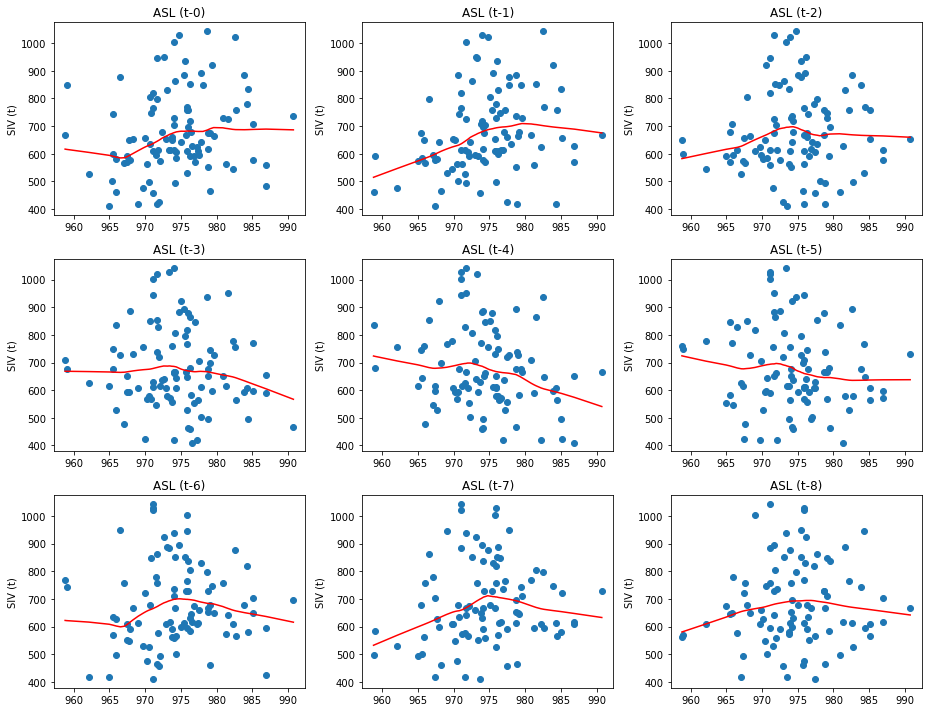

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols

from astsadata import *


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 10))

lag = 0
for row in range(3):
    for col in range(3):
        lowess = sm.nonparametric.lowess(df_vol.iloc[:, 0], df_asl.iloc[:, 0].shift(lag))
        axes[row, col].scatter(df_asl.shift(lag), df_vol)
        axes[row, col].set_title(f"ASL (t-{lag})")
        axes[row, col].set_ylabel("SIV (t)")
        axes[row, col].plot(lowess[:, 0], lowess[:, 1], color="red")
        lag += 1

fig.tight_layout()
plt.savefig("/Users/fridaperez/Developer/repos/local_repo/pub_plots/EA_ccf_ASL.png", dpi=300)
